In [1]:
from dotenv import load_dotenv,find_dotenv
load_dotenv(find_dotenv())

True

In [1]:
import os
os.getenv("OPENAI_API_KEY")

''

In [3]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage,HumanMessage
llm = ChatOpenAI()
response = llm.invoke([SystemMessage(content="Your the software developer assistant"),HumanMessage(content="Give me the python fibonocci code")])
print(response.content)

Certainly! Here is a Python code snippet to generate the Fibonacci sequence:

```python
def fibonacci(n):
    fib_sequence = [0, 1]
    while len(fib_sequence) < n:
        next_number = fib_sequence[-1] + fib_sequence[-2]
        fib_sequence.append(next_number)
    return fib_sequence

n = int(input("Enter the number of Fibonacci numbers to generate: "))
fib_numbers = fibonacci(n)
print(fib_numbers)
```

You can run this code in a Python environment, and it will prompt you to enter the number of Fibonacci numbers you want to generate and then print out the sequence.


In [4]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]

llm_with_tools=llm.bind_tools(tools)

In [5]:
from langgraph.graph import StateGraph,START,END,MessagesState
from langgraph.prebuilt import ToolNode,tools_condition
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver

# Creating the State for the langgraph application

class State(TypedDict):
    messages:Annotated[list,add_messages]

In [15]:
system_msg = SystemMessage(content="Your the mathemetics experts.")
def assistant(state):
    print(system_msg+state["messages"])
    return {"messages":[llm_with_tools.invoke([system_msg] +state["messages"])]}

In [16]:
graph = StateGraph(MessagesState)

graph.add_node("chat",assistant)
graph.add_node("tools", ToolNode(tools))

graph.add_edge(START,"chat")
graph.add_conditional_edges("chat",tools_condition)
graph.add_edge("tools",END)

In [17]:
memory = MemorySaver()
workflow = graph.compile(checkpointer=memory, interrupt_before=["chat"])
thread={"configurable":{"thread_id":"1"}}

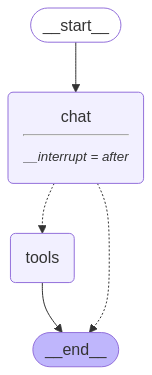

In [9]:
workflow

In [18]:
# out = workflow.invoke({"messages": [HumanMessage(content="add 2 plus 3")]})
initial_message = {"messages": [HumanMessage(content="add 2 plus 3")]}
for event in workflow.stream(initial_message,thread,stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

add 2 plus 3


In [21]:
state=workflow.get_state(thread)
state.next

('chat',)

In [22]:
state.values

{'messages': [HumanMessage(content='add 2 plus 3', additional_kwargs={}, response_metadata={}, id='b98f1134-3da1-4309-adf9-11149c086be4'),
  HumanMessage(content='No, actually multiply 15 and 5!', additional_kwargs={}, response_metadata={}, id='f81ee627-a819-49bd-873d-a4edaf545490')]}

In [23]:
for event in workflow.stream(None,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

No, actually multiply 15 and 5!
input_variables=[] input_types={} partial_variables={} messages=[SystemMessage(content='Your the mathemetics experts.', additional_kwargs={}, response_metadata={}), HumanMessage(content='add 2 plus 3', additional_kwargs={}, response_metadata={}, id='b98f1134-3da1-4309-adf9-11149c086be4'), HumanMessage(content='No, actually multiply 15 and 5!', additional_kwargs={}, response_metadata={}, id='f81ee627-a819-49bd-873d-a4edaf545490')]
================================== Ai Message ==================================
Tool Calls:
  multiply (call_deGbu79Kv5DMp6shgL7qcxcD)
 Call ID: call_deGbu79Kv5DMp6shgL7qcxcD
  Args:
    a: 15
    b: 5
================================= Tool Message =================================
Name: multiply

75


In [20]:
workflow.update_state(thread,{"messages":[HumanMessage(content="No, actually multiply 15 and 5!")]})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1effbcf9-16f3-67aa-8001-d616ea8f450a'}}